In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from bokeh.io import output_notebook, show
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
from OCP_algorithms import hospital_capacity_objective_solve, quadratic_objective_solve, week_objective_solve

from SIR_Plotting_Routines import *
import pysindy as ps
import glob
import pandas as pd


from os.path import basename
import os
import sys


cwd = os.path.dirname(os.path.abspath(''))
# sys.path.append(cwd + '/Cpp/build/Binders/')
import pyFROLS as pf

DATA_DIR = cwd + '/Cpp/data/'
FIGURE_DIR = cwd + '/../../figures/'

In [2]:
N_pop = 100
p_ER = 1
d_max = 1
N_output_max = 80
Nx = 3
Nu = 1
Nt = 50
er_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
er_features = er_model.read_csv(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')
#er_model.feature_summary()


In [3]:
qr_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
qr_features = qr_model.read_csv(DATA_DIR + 'Quantile_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')
# qr_model.feature_summary()

In [4]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs


In [5]:
def load_SIR_trajectories():
    trajs = glob.glob(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/trajectory*.csv')
    dfs = [pd.read_csv(traj) for traj in trajs[:100] if "Quantile" not in traj]
    
    print(dfs[0].columns)
    N_traj = len(dfs)
    X = [df[['S', 'I', 'R']].to_numpy() for df in dfs]
    U = [df['p_I'].to_numpy() for df in dfs]

    return X, U

X_sim, U_sim = load_SIR_trajectories()
#get mean of all X_sim
X_mean = np.mean(np.array(X_sim), axis=0)
U_mean = np.mean(np.array(U_sim), axis=0)

Index(['I', 'R', 'S', 'p_I', 't'], dtype='object')


In [6]:
Wu = 10000
t = np.array(range(0, Nt))

Nx = X_mean.shape[1]
Nu = 1
xk = cs.MX.sym('X', Nx)
uk = cs.MX.sym('U', Nu)
eqs = cs.vertcat(*construct_mx_equations(xk, uk, qr_model, qr_features))
qr_F = cs.Function('F', [xk, uk], [eqs])

eqs = cs.vertcat(*construct_mx_equations(xk, uk, er_model, er_features))
er_F = cs.Function('F', [xk, uk], [eqs])
u_max = np.max(U_sim)
# u_min = np.min(U_sim)
u_min = 1e-4
# (qr_sol, qr_X, qr_U) = quadratic_objective_solve(X_mean, U_mean, Wu, qr_F, Nt, u_min = u_min, u_max = 1.5*u_max)
# (er_sol, er_X, er_U) = quadratic_objective_solve(X_mean, U_mean, Wu, er_F, Nt, u_min = u_min, u_max = 1.5*u_max)
Nt = 500
(qr_sol, qr_X, qr_U) = week_objective_solve(X_mean, U_mean, Wu, qr_F, Nt, u_min = u_min, u_max = 1.5*u_max)
(er_sol, er_X, er_U) = week_objective_solve(X_mean, U_mean, Wu, er_F, Nt, u_min = u_min, u_max = 1.5*u_max)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2628

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

In [7]:

er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(er_U[0]))
qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(qr_U[0]))
er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]

size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100
size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100


ValueError: x and y must have same first dimension, but have shapes (50,) and (500, 1)

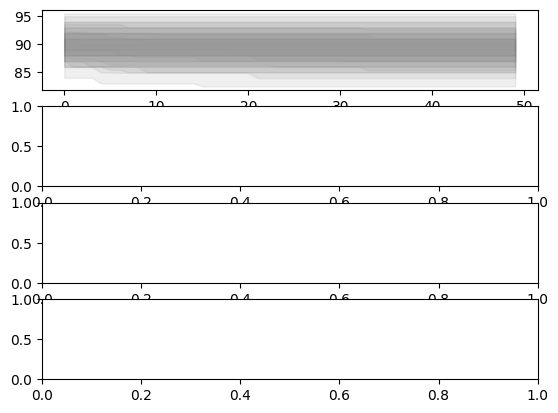

In [8]:

fig, ax = plt.subplots(4)

plot_sim_comparison_SIR(ax, er_X_list, X_mean, U_mean, er_X, er_U, t)

In [ ]:
X_stack = np.vstack([x.T[1,:] for x in X_sim])
U_stack = np.vstack([u for u in U_sim])

(100, 50)

ValueError: x and y must have same first dimension, but have shapes (50,) and (500, 1)

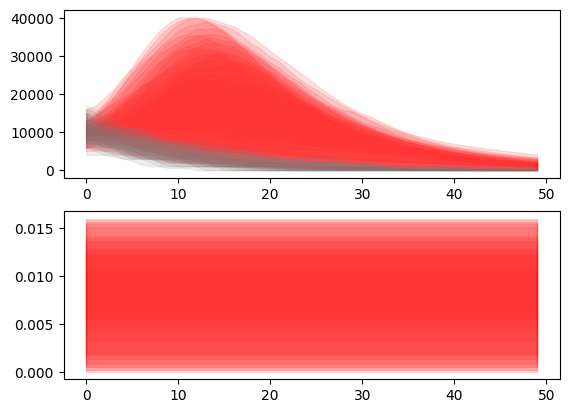

In [ ]:
fig, ax = plt.subplots(2)
fake_plot(ax, t, X_stack, U_stack, X_mean, qr_X_list, U_mean, qr_X, qr_U)
ax[-1].set_yscale('log')
ax[-1].set_yticklabels([])

In [ ]:
er_U

array([[9.99902952e-05, 9.99902952e-05, 9.99902952e-05, 9.99902952e-05,
        9.99902952e-05, 9.99902952e-05, 9.99902952e-05, 9.99921557e-05,
        9.99921557e-05, 9.99921557e-05, 9.99921557e-05, 9.99921557e-05,
        9.99921557e-05, 9.99921557e-05, 1.00009188e-04, 1.00009188e-04,
        1.00009188e-04, 1.00009188e-04, 1.00009188e-04, 1.00009188e-04,
        1.00009188e-04, 2.45302348e-03, 2.45302348e-03, 2.45302348e-03,
        2.45302348e-03, 2.45302348e-03, 2.45302348e-03, 2.45302348e-03,
        6.02540651e-03, 6.02540651e-03, 6.02540651e-03, 6.02540651e-03,
        6.02540651e-03, 6.02540651e-03, 6.02540651e-03, 8.55640978e-03,
        8.55640978e-03, 8.55640978e-03, 8.55640978e-03, 8.55640978e-03,
        8.55640978e-03, 8.55640978e-03, 1.36145686e-02, 1.36145686e-02,
        1.36145686e-02, 1.36145686e-02, 1.36145686e-02, 1.36145686e-02,
        1.36145686e-02, 2.03669185e-02, 2.03669185e-02, 2.03669185e-02,
        2.03669185e-02, 2.03669185e-02, 2.03669185e-02, 2.036691

In [ ]:
Wu = 1000
I_max = 25
(qr_sol, qr_X, qr_U) = hospital_capacity_objective_solve(X_mean, U_mean, Wu, I_max, qr_F, Nt)
(er_sol, er_X, er_U) = hospital_capacity_objective_solve(X_mean, U_mean, Wu, I_max, er_F, Nt)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1275
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3007742e+03 2.50e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [ ]:
er_sims_h = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(er_U[0]))
qr_sims_h = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(qr_U[0]))


size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100
size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100


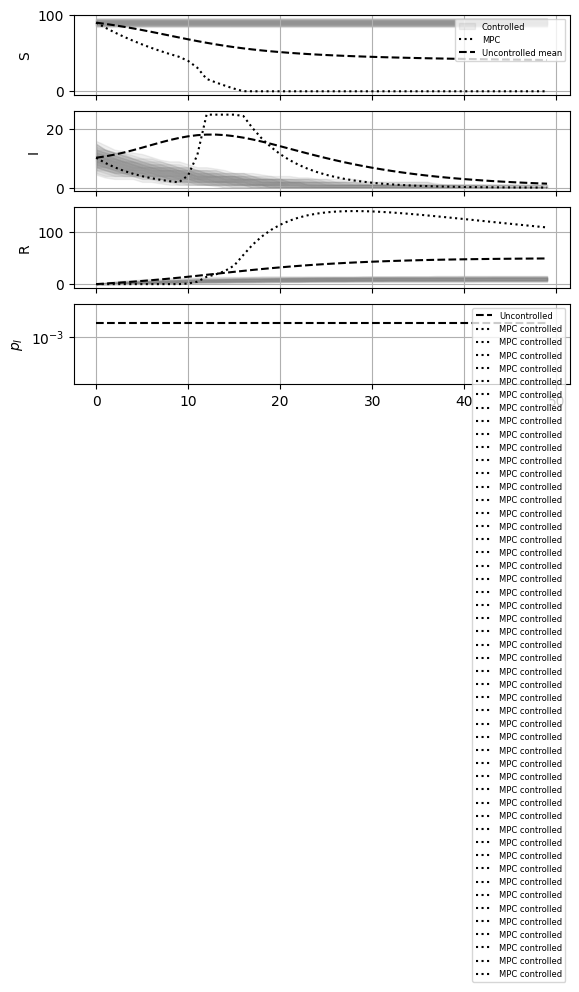

In [ ]:
er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims_h]
qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims_h]
fig, ax = plt.subplots(4)
plot_sim_comparison_SIR(ax, qr_X_list, X_mean, U_mean, qr_X, qr_U, t)

Text(0.5, 1.0, 'Hospital Capacity under Quantile Regression')

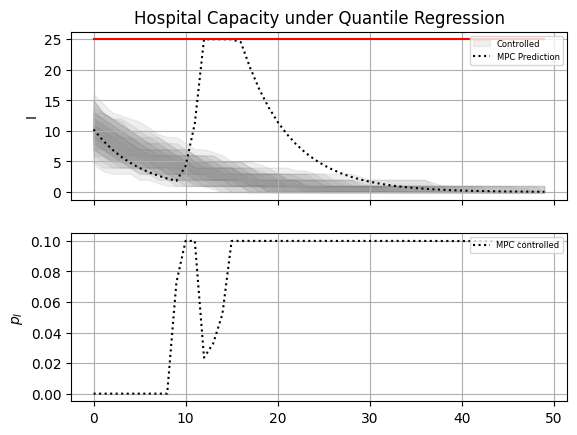

In [ ]:
fig, ax = plt.subplots(2)
plot_sim_comparison_I(ax, qr_X_list, X_mean, U_mean, qr_X, qr_U, t)
ax[0].plot(np.ones(Nt)*I_max, color='red', label='Hospital Capacity')
ax[0].set_title('Hospital Capacity under Quantile Regression')

Text(0.5, 1.0, 'Hospital Capacity under FROLS Regression')

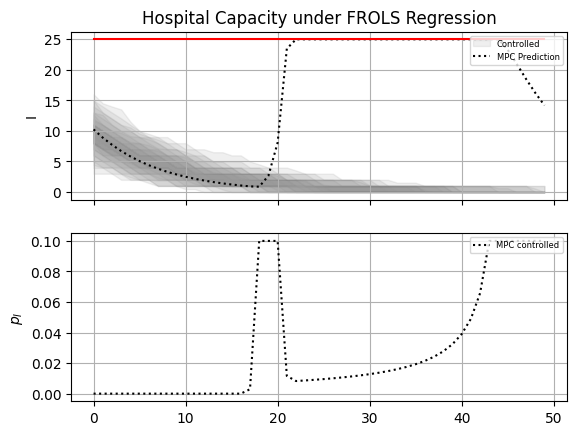

In [ ]:
fig, ax = plt.subplots(2)
plot_sim_comparison_I(ax, er_X_list, X_mean, U_mean, er_X, er_U, t)
ax[0].plot(np.ones(Nt)*I_max, color='red', label='Hospital Capacity')
ax[0].set_title('Hospital Capacity under FROLS Regression')